# Oil Palm Disease Detection

## Data Acquisition

Data collected from kaggle private dataset. The data was manually selected to 1000 out of a total of about 3000 images each class. Follow these steps:

0. Download the dataset and extract it.
1. Create `data` folder and put the extracted folder in here. `data` folder should now have 1 folder named `selected_dataset` inside.
2. Follow the code.

In [1]:
import os
import shutil

SELECTED_DATA = os.path.join('data', 'selected_dataset')
ORIGINAL_DATA = os.path.join('data', 'cleaned_dataset')
PROCESSED_DATASET = os.path.join('data', 'processed_dataset')
SAMPLE_IMAGE = 'data/selected_dataset/normal/DSC03990_5.JPG'

In [ ]:
def copy_selected(label: str) -> None:
    with open(f'selected_data_{label}.txt', 'r') as f:
        selected_list = [x.strip() for x in f.readlines()]
    for image_file in selected_list:
        src = os.path.join(ORIGINAL_DATA, label, image_file)
        dst = os.path.join(SELECTED_DATA, label, image_file)
        shutil.copyfile(src, dst)

copy_selected('normal')
copy_selected('infected')

## Preprocessing Image

Preprocessing image consist of image enhancing using histogram equalization and noise removal using bilateral smoothing filter.

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Union
import sys

In [9]:
def enhance(image: Union[str, np.ndarray], display: bool = False) -> np.ndarray:
    """
    Enhance image by using adaptive histogram equalization
    :param display: bool, if true then return converted image in RGB, if not, return as BGR because it needs to continue to another preprocessing
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of enhance image
    """
    if type(image) is str:
        image = cv2.imread(image)
    # convert from BGR to YCrCb
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    # create clahe object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # equalize the histogram of the Y channel
    ycrcb[:, :, 0] = clahe.apply(ycrcb[:, :, 0])
    # convert the YCR_CB image back to RGB format
    if display:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    else:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR)

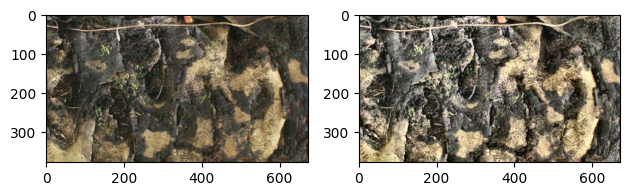

In [10]:
# cv2.imwrite('data/samples/equalized_img.jpg', enhance('data/selected_dataset/normal/DSC03977_4.JPG'))
# cv2.waitKey(0)
def compare_image(image: str, processed_image: np.ndarray):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(Image.open(image))
    ax[1].imshow(processed_image)
    plt.tight_layout()

compare_image(SAMPLE_IMAGE, enhance(SAMPLE_IMAGE, display=True))

In [11]:
def remove_noise(image: Union[str, np.ndarray], filter: str = 'bilateral', display: bool = False) -> np.ndarray:
    """
    Remove noise from image using bilateral filter
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of image with removed noise
    """
    if type(image) is str:
        image = cv2.imread(image)
    # apply bilateral filter with d = 15, sigmaColor = sigmaSpace = 75.

    if filter == 'bilateral':
        filtered_image = cv2.bilateralFilter(image, 10, 65, 65)
    elif filter == 'median':
        filtered_image = cv2.medianBlur(image, 5)
    else:
        raise ValueError('Unrecognized filter')

    if display:
        return cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
    return filtered_image

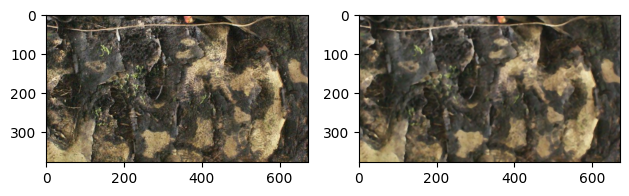

In [12]:
compare_image(SAMPLE_IMAGE, remove_noise(SAMPLE_IMAGE, filter='median', display=True))

In [13]:
def resize(image: Union[str, np.ndarray], size: int = 256) -> np.ndarray:
    """
    Resize image
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :param size: int, size of image
    :return: np.ndarray, numpy array of image with removed noise
    """
    if type(image) is str:
        image = cv2.imread(image)
    resized_image = cv2.resize(image, (size, size))
    return resized_image

### Apply preprocessing

In [14]:
if not os.path.exists(PROCESSED_DATASET):
    os.makedirs(PROCESSED_DATASET)

for image_class in os.listdir(SELECTED_DATA):
    if not os.path.exists(os.path.join(PROCESSED_DATASET, image_class)):
        os.makedirs(os.path.join(PROCESSED_DATASET, image_class))
    for image_file in os.listdir(os.path.join(SELECTED_DATA, image_class)):
        image_path = os.path.join(SELECTED_DATA, image_class, image_file)
        image = enhance(image_path)
        image = remove_noise(image, filter='median')
        image = resize(image)
        sys.stdout.write(f"\rWriting {image_file} to {PROCESSED_DATASET}")
        sys.stdout.flush()
        cv2.imwrite(os.path.join(PROCESSED_DATASET, image_class, image_file), image)

Writing DSC04873_9.JPG to data\processed_dataset

## Feature Extraction

Feature extraction using LBP, Color moments, and Hu-moments.

In [16]:
import cv2
from skimage import io
from skimage.feature import local_binary_pattern
import numpy as np
from typing import Union

In [19]:
def lbp(image: Union[np.ndarray, str], radius: int = 3,  n_points: int = 8, methods: str = 'uniform') -> np.ndarray:
    """
    Calculate Local Binary Pattern of an image.
    :param image: input image
    :param radius: radius of LBP
    :param n_points: number of points
    :param methods: methods to use for LBP
    :return: LBP histogram
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    lbp = local_binary_pattern(image, n_points, radius, method=methods)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    # normalize the histogram
    # hist = hist.astype('float')
    # hist /= (hist.sum() + 1e-7)

    return hist.astype('float')

lbp(SAMPLE_IMAGE)

array([20751., 24686., 16712., 17377., 19412., 16729., 16137., 24458.,
       22868., 74886.])

In [20]:
def color_moment(image: Union[np.ndarray, str]) -> np.ndarray:
    """
    Calculate color moment of an image (mean, standard deviation, skewness, kurtosis).
    :param image: input image
    :return: color moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = io.imread(image)
    # mean of each channel
    mean = np.mean(image, axis=(0, 1))
    # standard deviation of each channel
    std = np.std(image, axis=(0, 1))
    # skewness of each channel
    skew = np.mean(np.power(image - mean, 3)) / np.power(std, 3)
    # kurtosis of each channel
    kurt = np.mean(np.power(image - mean, 4)) / np.power(std, 4)
    return np.concatenate((mean, std, skew, kurt))

color_moment(SAMPLE_IMAGE)

array([92.32898715, 83.8765314 , 67.20685311, 49.26675293, 43.04963224,
       34.40291865,  0.61395685,  0.92021929,  1.80307505,  1.91872026,
        3.29116486,  8.06949331])

In [21]:
def hu_moment(image: Union[np.ndarray, str]) -> np.ndarray:
    """
    Calculate Hu moment of an image.
    :param image: input image
    :return: Hu moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # compute moments
    moments = cv2.HuMoments(cv2.moments(image)).flatten()
    return moments

hu_moment(SAMPLE_IMAGE)

array([ 2.30352710e-03,  1.36658857e-06,  7.30230907e-11,  7.99031976e-11,
        4.03872355e-21,  8.80721041e-14, -4.57613129e-21])

In [98]:
import csv

lbp_columns = [f'lbp_{x}' for x in range(1, 11)]
color_columns = []
for moments in ['mean', 'std', 'skew', 'kurt']:
    for color_channel in ['R', 'G', 'B']:
        color_columns.append(f'{moments}_{color_channel}')
hu_moment_columns = [f'humoment_{x}' for x in range(1, 8)]
header = ['is_infected'] + lbp_columns + color_columns + hu_moment_columns

# combine all feature
def extract_feature(data_path: str, csv_name: str) -> str:
    """
    Extract feature from images in data_path and save it to csv.
    The extracted feature is texture (LBP), color (color moment), shape (hu-moment)
    :param data_path: str, the path to where the classes folder is
    :param csv_name: str, the name of the csv file
    :return: str, path to csv file containing extracted feature of all image
    """
    f = open(os.path.join('data', f'{csv_name}.csv'), 'w', newline='')
    writer = csv.writer(f)

    writer.writerow(header)

    class_map = {'infected': 1, 'normal':0}
    for image_class in os.listdir(os.path.join(data_path)):
        for image_file in os.listdir(os.path.join(data_path, image_class)):
            image_path = os.path.join(data_path, image_class, image_file)
            extracted_lbp = lbp(image_path)
            extracted_color_moment = color_moment(image_path)
            extracted_humoment = hu_moment(image_path)
            all_features = np.concatenate([extracted_lbp, extracted_color_moment, extracted_humoment])
            # print(all_features)

            # write to csv. Column position is as follows
            # first column would be image class. 0 for normal, 1 for infected. Then, next columns would be
            # 10 lbp feature, 12 color moment feature, and 7 hu-moment
            data = all_features.tolist()
            data.insert(0, class_map[image_class])
            writer.writerow(data)

    f.close()
    return f.name

In [23]:
processed_img_feature = extract_feature(PROCESSED_DATASET, 'processed_img_feature')
orig_img_feature = extract_feature(SELECTED_DATA, 'orig_img_feature')

## Feature Selection

The final feature which will be classified later for comparison is following this pattern.

- Color
- Texture
- Shape
- Color-texture
- Color-shape
- Texture-shape
- Color-texture-shape
- Color-texture-shape (feature selection)

Therefore, we apply feature selection only on the whole feature set. The feature selection method consist of.

- PCA
- Mutual Information
- SelectFromModel

In [6]:
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn import svm
from sklearn.feature_selection import SelectFromModel

In [16]:
proc_img_df = pd.read_csv(os.path.join('data', 'processed_img_feature.csv'), names=header)
orig_img_df = pd.read_csv(os.path.join('data', 'orig_img_feature.csv'), names=header)

orig_img_df.head(2)

,is_infected,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,...,kurt_R,kurt_G,kurt_B,humoment_1,humoment_2,humoment_3,humoment_4,humoment_5,humoment_6,humoment_7
0,1,19897.0,23707.0,17165.0,18050.0,22068.0,18252.0,16150.0,24186.0,22328.0,...,2.777283,4.164554,12.812995,0.002660,0.000002,5.056881e-10,1.996583e-10,5.404732e-20,2.542200e-13,-3.322191e-20
1,1,18626.0,22696.0,16941.0,20107.0,29579.0,19662.0,16754.0,23169.0,20324.0,...,2.241795,2.729686,7.897771,0.002124,0.000001,5.481881e-11,1.635459e-10,1.515469e-20,1.691927e-13,-3.183560e-21


In [18]:
# separate the feature and label
proc_img_label = proc_img_df.pop('is_infected')
orig_img_label = orig_img_df.pop('is_infected')

### PCA

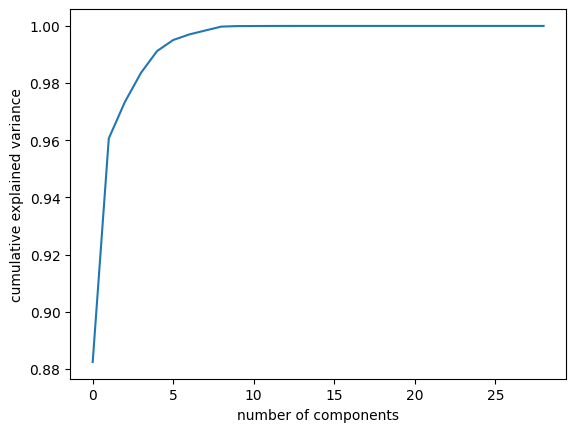

In [59]:
# determine the number of components
pca = PCA().fit(proc_img_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [68]:
N_COMPONENTS = 9

In [61]:
pca = PCA(n_components=N_COMPONENTS)
reduced_proc_img = pca.fit_transform(proc_img_df)
reduced_proc_img

array([[ 1.40036715e+03, -4.75008962e+02, -5.06938404e+01, ...,
        -1.05289959e+02, -8.17718120e+01,  9.43678910e+00],
       [ 8.68484905e+02,  4.61162078e+02, -2.98294079e+02, ...,
         1.14500156e+02,  2.54894382e+01,  3.58083730e+01],
       [-3.07913368e+03, -3.73926464e+02,  3.38736266e+02, ...,
         7.10855230e+01,  6.02497252e+01,  4.21321560e+01],
       ...,
       [ 9.07990676e+03,  4.32428482e+02,  1.98785664e+02, ...,
         2.71288465e+01,  5.55168993e+01, -1.85562358e+02],
       [ 1.80433901e+03,  3.71245759e+02, -5.84903073e+02, ...,
         1.70416758e+01,  4.24382193e+01,  2.60042482e+01],
       [ 2.20121558e+03,  4.31143707e+00, -4.13134755e+02, ...,
         7.92190730e+01,  1.77877787e+02, -6.30575762e-01]])

In [62]:
pca = PCA(n_components=N_COMPONENTS)
reduced_orig_img = pca.fit_transform(orig_img_df)
reduced_orig_img

array([[-8.94752960e+03,  5.57762773e+01, -2.19109700e+02, ...,
        -7.62441319e+01, -5.48366603e+02,  6.59830182e+01],
       [ 8.03581123e+02,  2.89868613e+03, -1.17759370e+03, ...,
         4.39965236e+00,  2.97499888e+02, -2.16262390e+01],
       [-1.45613357e+04, -1.08607635e+03, -4.69030309e+02, ...,
         2.21447719e+02,  2.33823276e+02, -9.29876912e+01],
       ...,
       [ 1.72673007e+04,  3.76645261e+03,  1.47831962e+03, ...,
        -2.34511404e+02,  8.14054328e+02, -1.28201044e+02],
       [ 5.35471132e+03,  5.45571772e+03, -1.75641396e+02, ...,
         3.22856888e+02, -2.80702448e+02, -3.50108559e+02],
       [ 1.15658495e+04,  3.35430431e+03, -4.95584265e+02, ...,
        -6.59214340e+01, -3.16687331e+02, -4.78348391e+02]])

In [63]:
pca_header = ''.join([f'pca_{x}' for x in range(1, N_COMPONENTS+1)])
np.savetxt(os.path.join('data', 'reduced_processed_img_features_PCA.csv'), reduced_proc_img, delimiter=',', header=pca_header)
np.savetxt(os.path.join('data', 'reduced_orig_img_features_PCA.csv'), reduced_orig_img, delimiter=',', header=pca_header)

### Mutual Information

In [64]:
mi = mutual_info_classif(proc_img_df, proc_img_label)
mi

array([0.00136697, 0.0229433 , 0.07296286, 0.02437957, 0.        ,
       0.00739504, 0.01858548, 0.01701467, 0.00978983, 0.        ,
       0.01270494, 0.02357088, 0.0404842 , 0.00369993, 0.01992307,
       0.0639595 , 0.02784805, 0.02733696, 0.04301907, 0.01924383,
       0.        , 0.06888436, 0.03162382, 0.01184386, 0.00156319,
       0.02406732, 0.01258312, 0.        , 0.02839272])

In [65]:
sorted_indices = np.argsort(mi)
top_indices = sorted_indices[-9:]
reduced_proc_img_features_mi = proc_img_df.iloc[:, top_indices]
reduced_proc_img_features_mi

,skew_G,skew_R,humoment_7,humoment_1,mean_B,skew_B,std_B,kurt_B,lbp_3
0,0.448711,0.360700,5.356591e-23,0.001659,85.241821,0.754803,41.889256,4.902600,4961.0
1,0.416346,0.376317,-4.361165e-23,0.001518,86.597458,0.777339,46.148004,4.624784,4465.0
2,0.325619,0.249088,-1.034239e-22,0.001563,79.924026,0.630324,39.625862,5.589271,4633.0
3,0.759140,0.566426,-2.279781e-22,0.001754,81.439819,1.024855,38.906003,4.968798,4369.0
4,0.328594,0.290527,-3.241599e-22,0.001574,89.160889,0.510567,45.489044,3.899833,4535.0
...,...,...,...,...,...,...,...,...,...
1995,2.009088,1.270484,-6.312406e-23,0.002597,50.122574,2.702950,31.264631,12.231343,5010.0
1996,1.077181,0.981185,-2.248483e-20,0.002090,45.845963,4.268635,34.692126,19.972633,5269.0
1997,0.713769,0.660351,-6.421062e-22,0.001580,70.095688,1.071380,50.482576,4.583526,5098.0
1998,1.042984,0.804943,1.095467e-21,0.002039,62.570328,2.038497,41.175131,8.156699,4355.0


In [66]:
mi = mutual_info_classif(orig_img_df, orig_img_label)
sorted_indices = np.argsort(mi)
top_indices = sorted_indices[-9:]
reduced_orig_img_features_mi = orig_img_df.iloc[:, top_indices]
reduced_orig_img_features_mi

,kurt_R,lbp_9,humoment_2,humoment_1,lbp_8,skew_B,mean_B,kurt_B,std_B
0,2.777283,22328.0,0.000002,0.002660,24186.0,2.469259,58.554717,12.812995,29.313368
1,2.241795,20324.0,0.000001,0.002124,23169.0,1.573698,68.283947,7.897771,35.670507
2,1.613546,23352.0,0.000001,0.002132,25183.0,1.408063,62.868957,7.645954,36.787138
3,3.480560,24731.0,0.000002,0.002801,25918.0,2.162133,55.591101,10.598379,27.676413
4,2.257844,22810.0,0.000001,0.002256,24708.0,0.883954,65.850482,6.074232,34.734952
...,...,...,...,...,...,...,...,...,...
1995,11.548131,20892.0,0.000007,0.004882,22969.0,5.926426,26.648443,39.787443,22.834124
1996,3.469993,19281.0,0.000002,0.002806,21675.0,5.694804,29.245429,26.500547,34.170456
1997,2.951485,17045.0,0.000001,0.002058,20609.0,1.614087,58.335506,6.579906,47.567790
1998,4.553553,20412.0,0.000002,0.003240,22441.0,4.563653,38.003992,23.397154,31.004115


In [67]:
# save the reduced feature
reduced_proc_img_features_mi.to_csv(os.path.join('data', 'reduced_processed_img_features_mi.csv'), index=False)
reduced_orig_img_features_mi.to_csv(os.path.join('data', 'reduced_orig_img_features_mi.csv'), index=False)

### SelectFromModel

We are using SVM-FS. There isn't specific library for SVM-based feature selection out-of-the-box. But we can use `SelectFromModel` from scikit-learn.

In [12]:
clf = svm.SVC(kernel='linear')
selector = SelectFromModel(clf, prefit=False)
selector.fit(proc_img_df, proc_img_label)
selected_feature = selector.transform(proc_img_df)
selected_feature

array([[109.09487915, 102.37854004,  85.24182129, ...,   1.83165107,
          2.45059047,   4.90260048],
       [115.99746704, 109.3888092 ,  86.59745789, ...,   1.75799015,
          2.01163869,   4.6247838 ],
       [116.70397949, 104.96469116,  79.92402649, ...,   1.62083702,
          2.31676716,   5.58927149],
       ...,
       [117.78625488, 106.5869751 ,  70.09568787, ...,   2.40422242,
          2.66697305,   4.58352623],
       [ 89.50860596,  77.00125122,  62.57032776, ...,   2.36294815,
          3.33788078,   8.15669913],
       [115.73577881,  94.54386902,  68.24661255, ...,   1.69747098,
          2.40053821,   7.88359716]])

In [58]:
mask = np.isin(proc_img_df.values, selected_feature)
index_column = np.where(np.all(mask, axis=0))
reduced_proc_img_features_svmfs = proc_img_df.iloc[:, index_column[0]]
reduced_proc_img_features_svmfs

,mean_R,mean_G,mean_B,std_R,std_G,std_B,skew_G,skew_B,kurt_R,kurt_G,kurt_B
0,109.094879,102.378540,85.241821,53.579491,49.818608,41.889256,0.448711,0.754803,1.831651,2.450590,4.902600
1,115.997467,109.388809,86.597458,58.772162,56.824848,46.148004,0.416346,0.777339,1.757990,2.011639,4.624784
2,116.703979,104.964691,79.924026,53.998623,49.385212,39.625862,0.325619,0.630324,1.620837,2.316767,5.589271
3,100.988403,93.431213,81.439819,47.408512,42.999517,38.906003,0.759140,1.024855,2.253681,3.330148,4.968798
4,110.262482,104.846512,89.160889,54.894536,52.687126,45.489044,0.328594,0.510567,1.838894,2.166982,3.899833
...,...,...,...,...,...,...,...,...,...,...,...
1995,72.466995,60.380219,50.122574,40.210821,34.514349,31.264631,2.009088,2.702950,4.470084,8.235475,12.231343
1996,98.082321,84.738388,45.845963,56.633964,54.898993,34.692126,1.077181,4.268635,2.812232,3.184942,19.972633
1997,117.786255,106.586975,70.095688,59.319541,57.801190,50.482576,0.713769,1.071380,2.404222,2.666973,4.583526
1998,89.508606,77.001251,62.570328,56.124186,51.480873,41.175131,1.042984,2.038497,2.362948,3.337881,8.156699


In [59]:
clf = svm.SVC(kernel='linear')
selector = SelectFromModel(clf, prefit=False)
selector.fit(orig_img_df, orig_img_label)
selected_feature = selector.transform(orig_img_df)
mask = np.isin(orig_img_df.values, selected_feature)
index_column = np.where(np.all(mask, axis=0))
reduced_orig_img_features_svmfs = orig_img_df.iloc[:, index_column[0]]
reduced_orig_img_features_svmfs

,mean_R,mean_G,mean_B,std_R,std_B,skew_B,kurt_R,kurt_B
0,82.368595,75.567161,58.554717,42.960896,29.313368,2.469259,2.777283,12.812995
1,97.571558,90.929874,68.283947,48.869335,35.670507,1.573698,2.241795,7.897771
2,99.592333,87.766050,62.868957,54.276096,36.787138,1.408063,1.613546,7.645954
3,75.083601,67.445696,55.591101,36.560101,27.676413,2.162133,3.480560,10.598379
4,86.888716,81.405093,65.850482,44.485254,34.734952,0.883954,2.257844,6.074232
...,...,...,...,...,...,...,...,...
1995,48.943413,36.754681,26.648443,31.109493,22.834124,5.926426,11.548131,39.787443
1996,82.316271,68.835876,29.245429,56.804446,34.170456,5.694804,3.469993,26.500547
1997,105.919816,94.679745,58.335506,58.124304,47.567790,1.614087,2.951485,6.579906
1998,64.893211,52.316445,38.003992,46.679103,31.004115,4.563653,4.553553,23.397154


In [60]:
reduced_proc_img_features_svmfs.to_csv(os.path.join('data', 'reduced_processed_img_features_svmfs.csv'), index=False)
reduced_orig_img_features_svmfs.to_csv(os.path.join('data', 'reduced_orig_img_features_svmfs.csv'), index=False)

## Classification

In [73]:
from typing import Union
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.pipeline import Pipeline

import pandas as pd
import os
import itertools
import glob
import re

In [58]:
metrics = ['f1', 'recall', 'precision', 'accuracy']
def classify_with_svm(X: np.ndarray, y: np.ndarray, kernel: str, scoring=metrics):
    pipe = Pipeline([
        ('normalize', MinMaxScaler()),
        ('classify', svm.SVC(kernel=kernel))
    ])
    result = cross_validate(pipe, X=X, y=y, cv=10, scoring=scoring)
    return result

### All features combination

In [128]:
features = {'lbp': header[1:11], 'color': header[11:23], 'humoment': header[23:]}
all_feat_comb = list(features.keys())
all_feat_comb += list(itertools.combinations(all_feat_comb, 2))
all_feat_comb += [tuple(features.keys())]
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
y = proc_img_label

def compare_combined_feature(filename):
    columns = ['names', 'fit_time'] + metrics
    comparison_df = pd.DataFrame(columns=columns)

    feature_file = os.path.join('data', filename)
    feature_df = pd.read_csv(feature_file)

    for kernel in kernels:
        for feature in all_feat_comb:
            if not isinstance(feature, str):
                feat_col_name = []
                name = ''
                for i in range(len(feature)):
                    feat_col_name += features[feature[i]]
                    name += f'{feature[i]}_'
            else:
                feat_col_name = features[feature]
                name = feature + '_'
            X = feature_df.loc[:, feat_col_name]
            # print(X.columns, kernel)
            result = classify_with_svm(X, y, kernel=kernel)
            comparison_df.loc[len(comparison_df.index)] = [f'{name}{kernel}',
                                                           result['fit_time'].mean(),
                                                           result['test_f1'].mean(),
                                                           result['test_recall'].mean(),
                                                           result['test_precision'].mean(),
                                                           result['test_accuracy'].mean()]

    csv_name = filename.split('_')[0] + '_classification_result.csv'
    comparison_df.to_csv(csv_name, index=False)

    comparison_df.set_index('names').iloc[:, 1:].plot.bar(figsize=(17, 7), title='Metrics comparison (higher better)')

    return comparison_df

D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedM

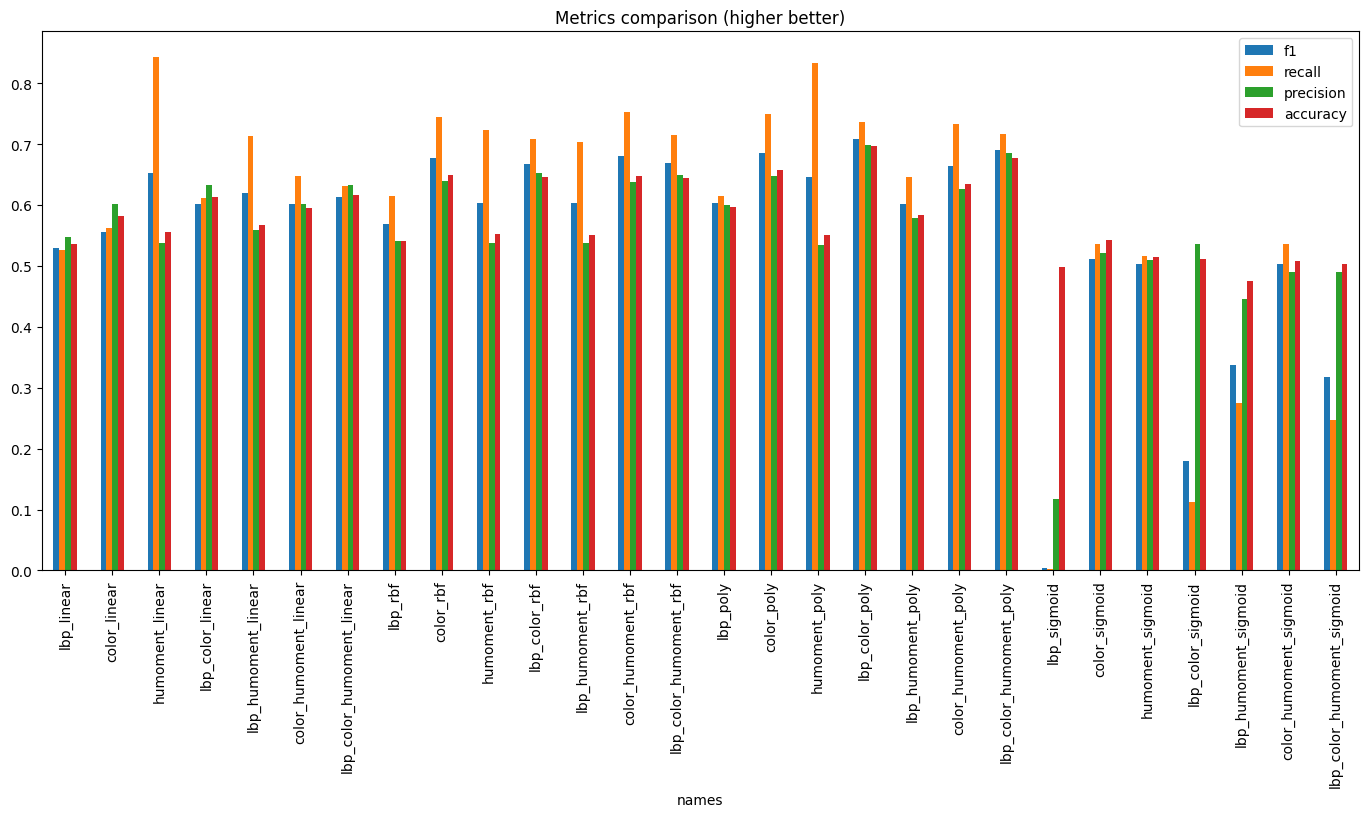

In [133]:
orig_img_compare_df = compare_combined_feature('orig_img_feature.csv')

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

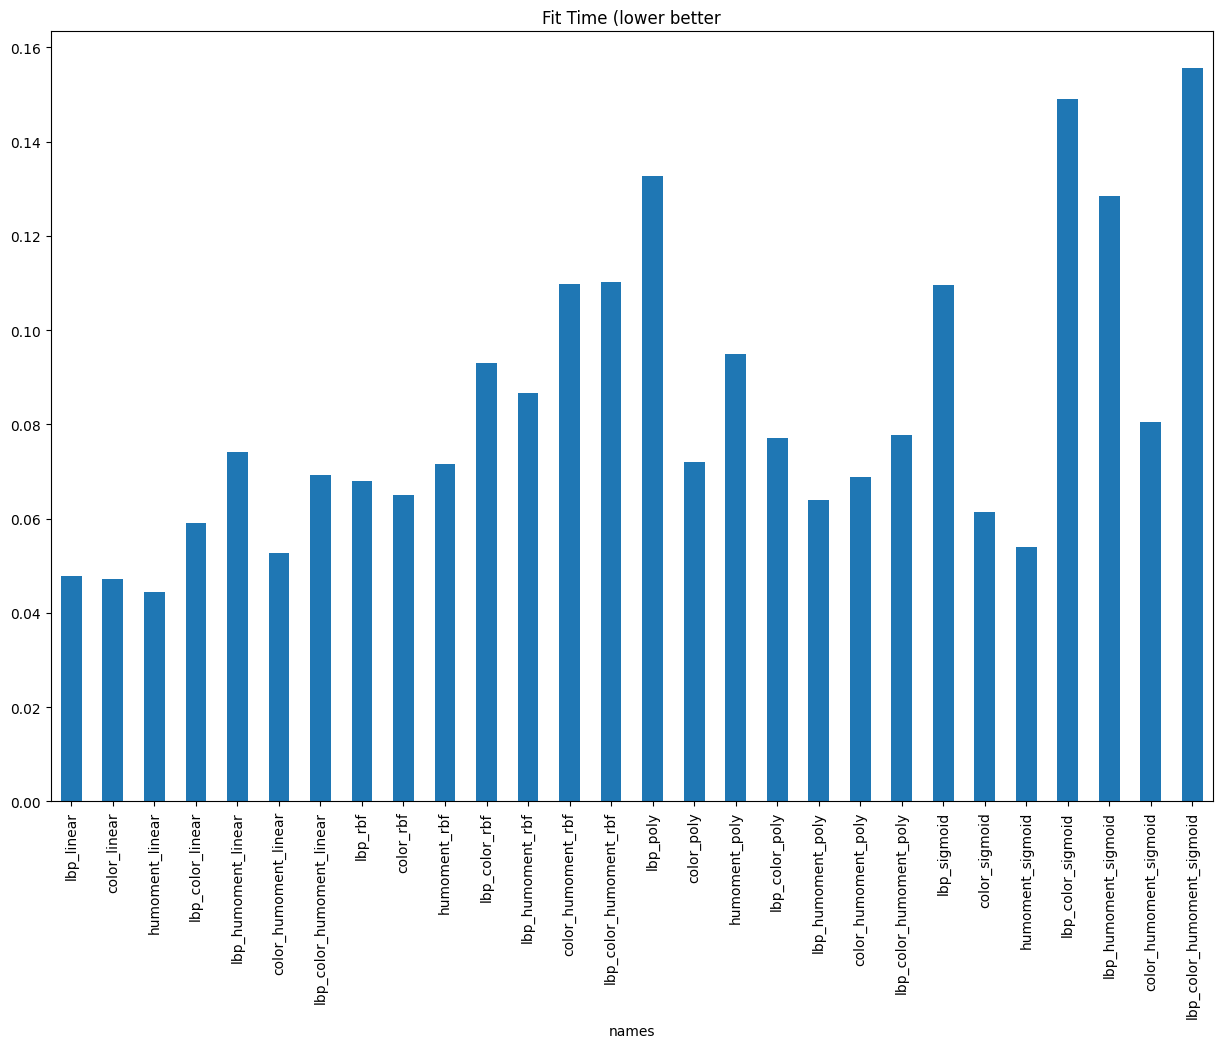

In [134]:
orig_img_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedM

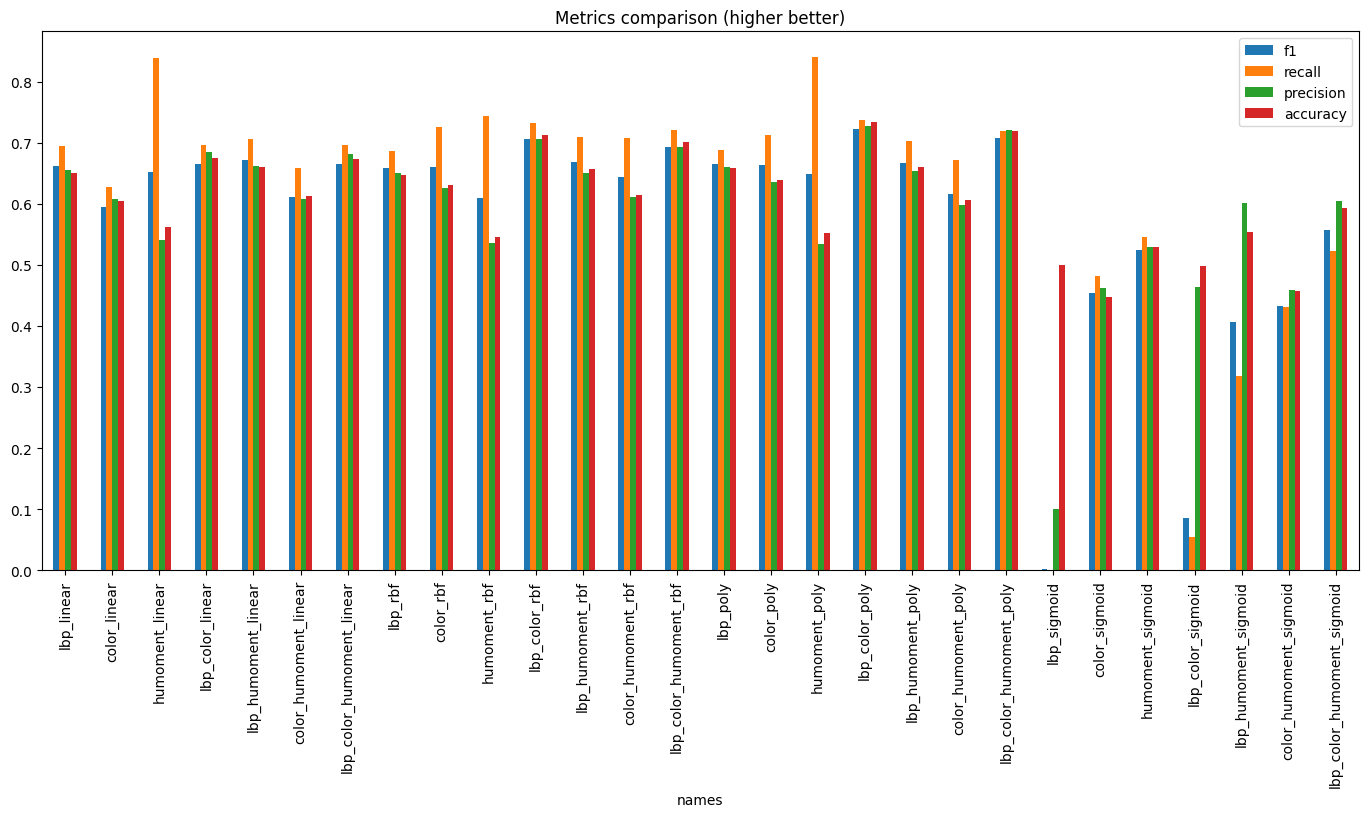

In [131]:
proc_img_compare_df = compare_combined_feature('processed_img_feature.csv')

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

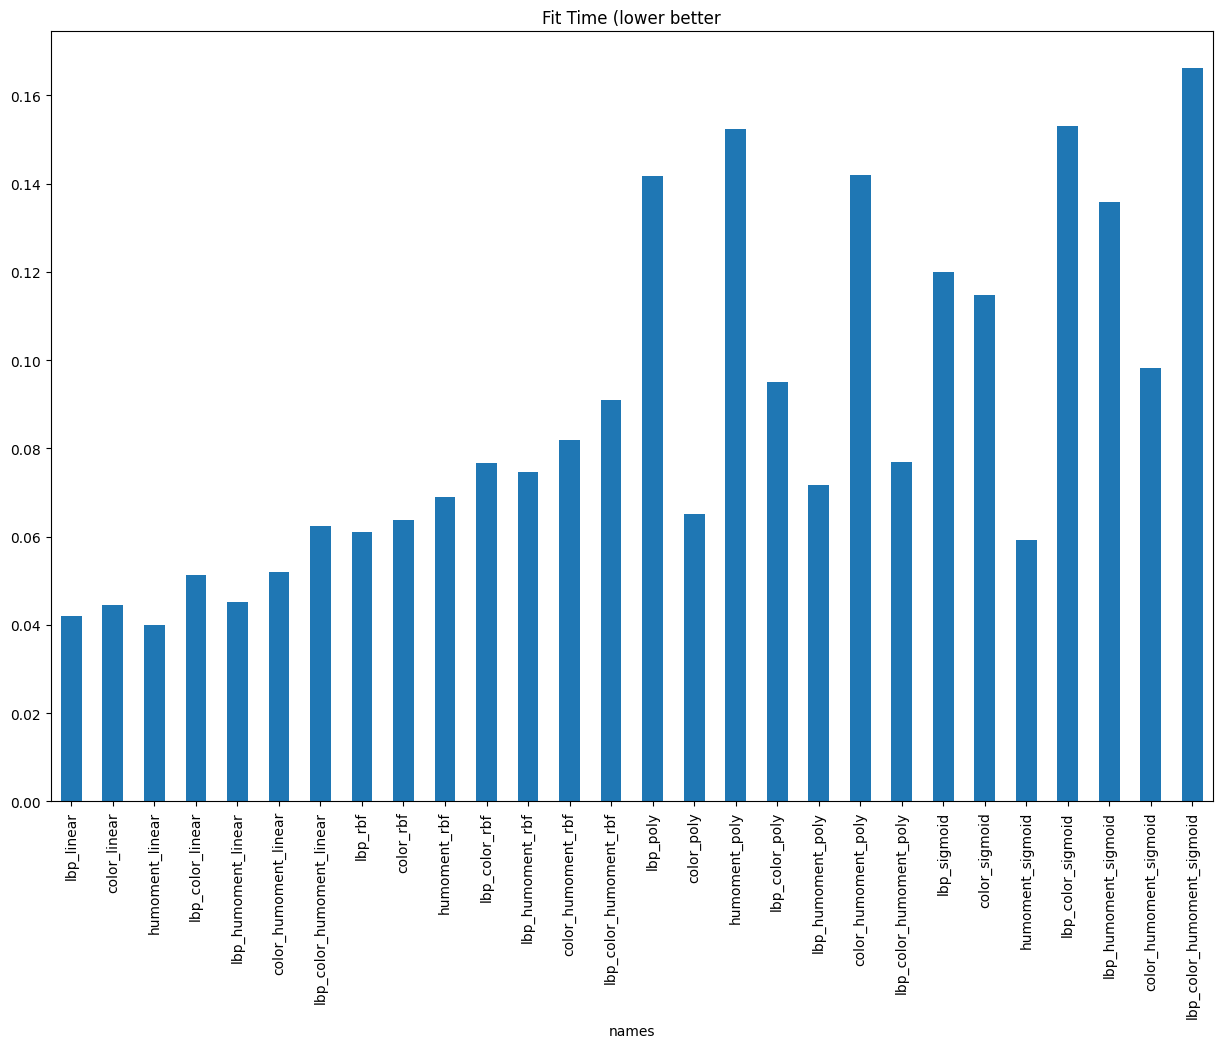

In [132]:
proc_img_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

### Reduced Feature

In [94]:
def compare_reduced_feature(csv_file_pattern):
    feature_files = glob.glob(os.path.join('data', csv_file_pattern))
    comparison_df = pd.DataFrame(columns=['names', 'fit_time']+metrics)

    for kernel in kernels:
        for feature_file in feature_files:
            X = pd.read_csv(feature_file)
            result = classify_with_svm(X, y, kernel=kernel)
            name = re.findall(r"s_(.*)\.csv", feature_file)[0] + f'_{kernel}'
            comparison_df.loc[len(comparison_df.index)] = [name,
                                                           result['fit_time'].mean(),
                                                           result['test_f1'].mean(),
                                                           result['test_recall'].mean(),
                                                           result['test_precision'].mean(),
                                                           result['test_accuracy'].mean()]

    comparison_df_name = csv_file_pattern.replace('*', '').replace('.csv', '_classification_result.csv')
    comparison_df.to_csv(comparison_df_name, index=False)

    comparison_df.set_index('names').iloc[:, 1:].plot.bar(figsize=(17, 7), title='Metrics comparison (higher better)')

    return comparison_df

D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


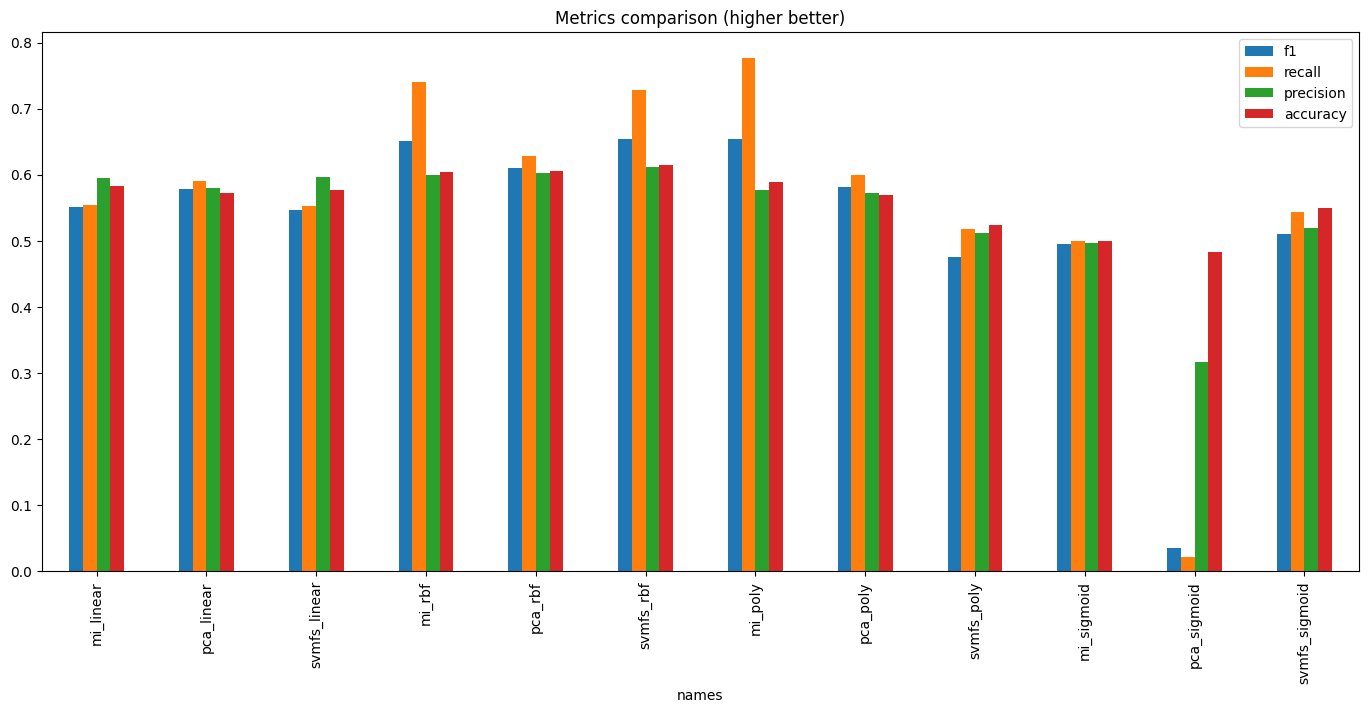

In [95]:
red_orig_compare_df = compare_reduced_feature('reduced_*orig*.csv')

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

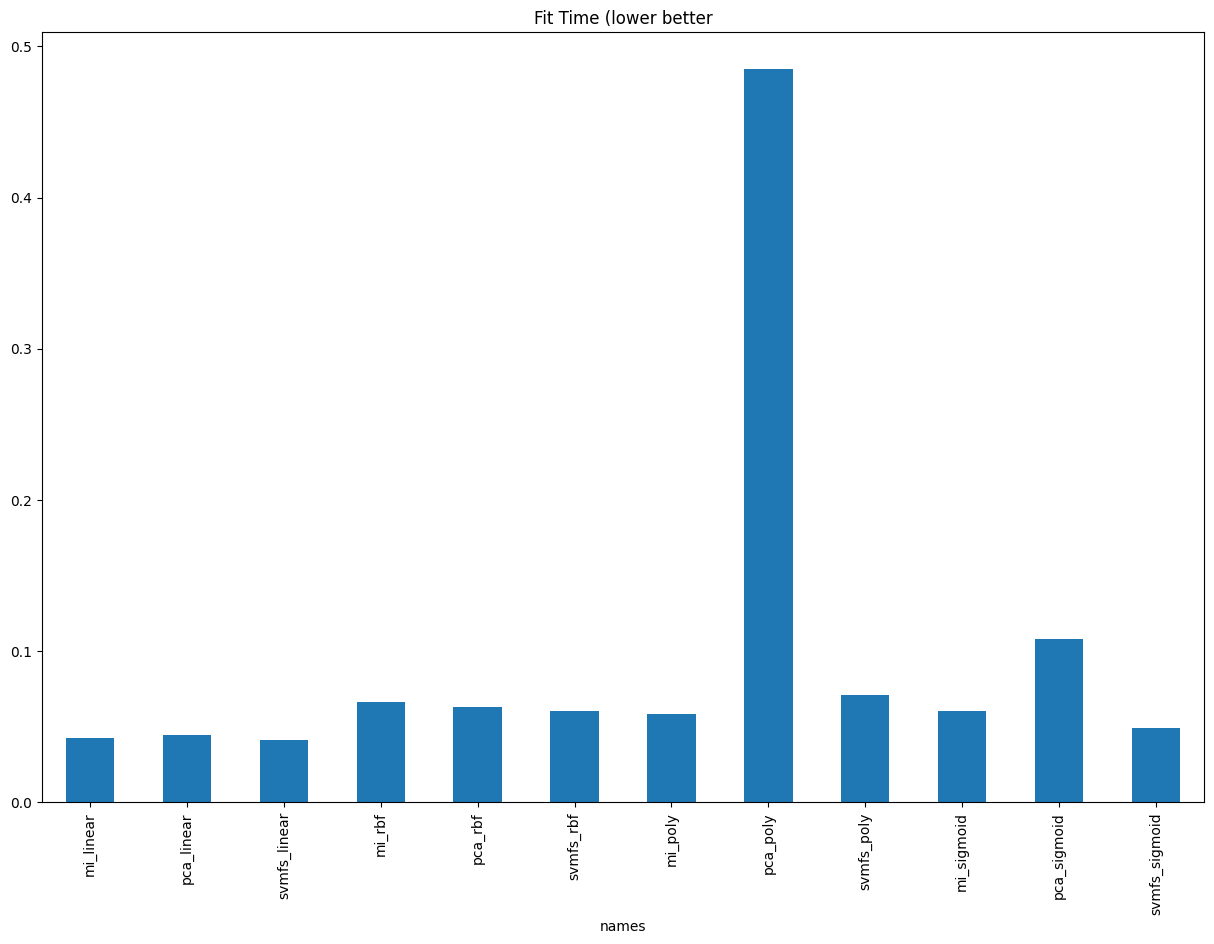

In [91]:
red_orig_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


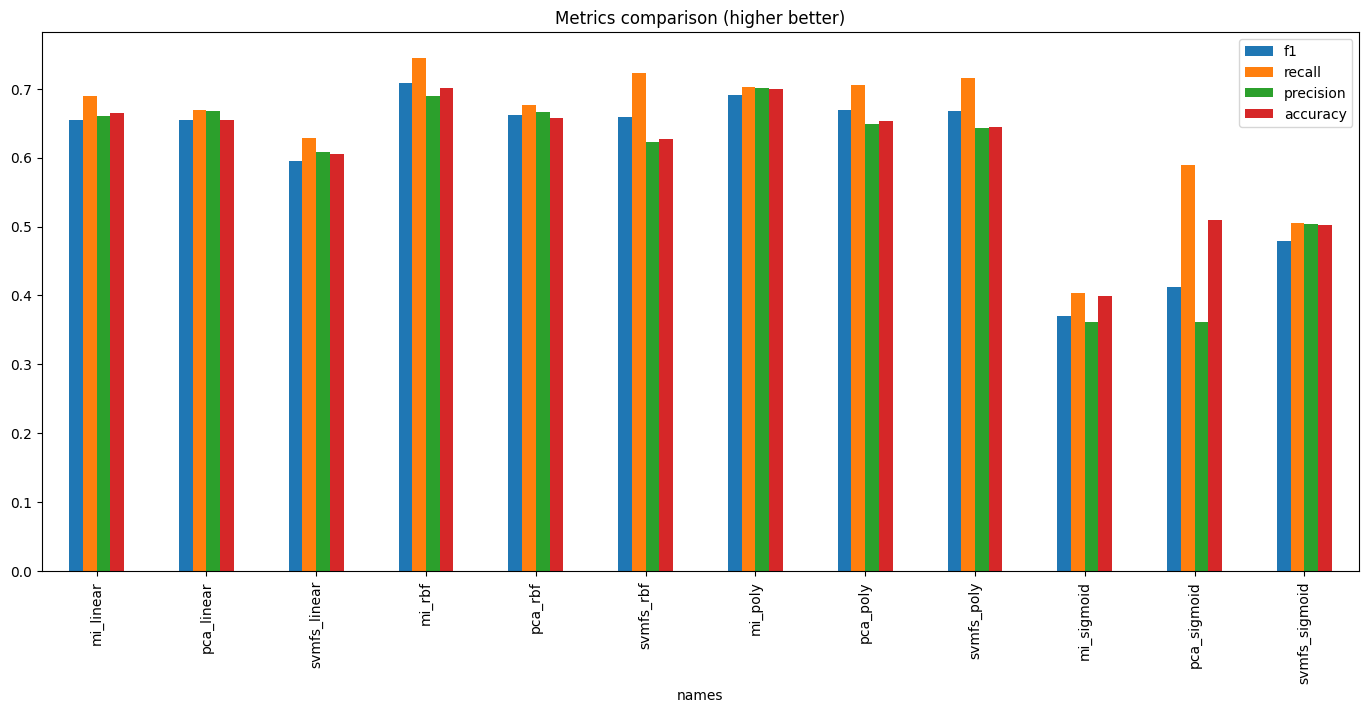

In [96]:
red_proc_compare_df = compare_reduced_feature('reduced_*proc*.csv')

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

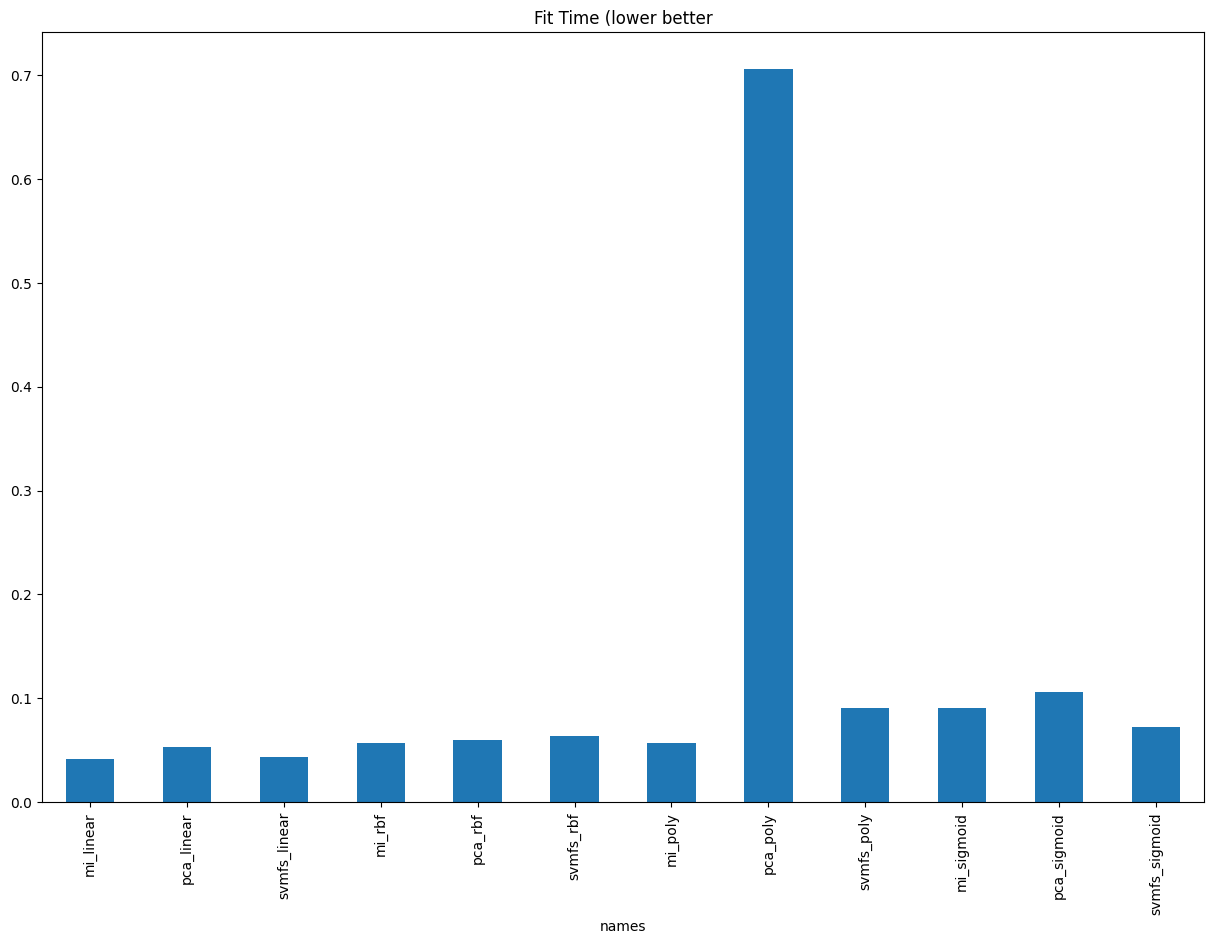

In [97]:
red_proc_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

In [115]:
red_orig_compare_df

,names,fit_time,f1,recall,precision,accuracy
0,mi_linear,0.053205,0.550793,0.554,0.594520,0.5835
1,pca_linear,0.062302,0.578644,0.590,0.579827,0.5725
2,svmfs_linear,0.041339,0.546661,0.553,0.596315,0.5765
3,mi_rbf,0.066100,0.651582,0.740,0.599089,0.6045
4,pca_rbf,0.063999,0.610626,0.629,0.602788,0.6055
5,svmfs_rbf,0.060600,0.653990,0.728,0.611271,0.6150
6,mi_poly,0.058200,0.653319,0.777,0.577450,0.5885
7,pca_poly,0.494300,0.581137,0.600,0.571852,0.5690
8,svmfs_poly,0.073802,0.475871,0.518,0.511354,0.5240
9,mi_sigmoid,0.061400,0.495395,0.500,0.495920,0.5000
